# Error Interpretation

On this notebook, the performance obtained by the selected model on the "Modelling" notebook is analised in more details, and two interpretations, one more suitable for business reports and another closer to the technical data science language.

## 1. Packages

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
sns.set_style('darkgrid')

## 2. Data Reading

On this section, the test data is imported along with the model predictions.

In [2]:
test_data = pd.read_pickle('../Data/prepared_test_data.pkl')
model_predictions = pd.read_pickle('../Data/model_predictions.pkl')

In [3]:
test_data['sales'] = np.expm1(test_data['sales'])
test_data['predictions'] = np.expm1(model_predictions['Predictions'].values)

test_data.head()

store  promo  store_type  assortment  competition_distance  competition_open_since_month  competition_open_since_year  promo2  promo2_since_week  promo2_since_year  competition_time_month  promo_time_week   day_sin   day_cos  day_of_week_sin  day_of_week_cos  week_of_year_sin  week_of_year_cos  month_sin  month_cos       date    sales   predictions
0      1      1           2           1             -0.170968                             9                         2008       0                 31               2015                0.918919         0.287016  0.207912  0.978148        -0.974928        -0.222521         -0.568065         -0.822984       -0.5  -0.866025 2015-07-31   5263.0   5534.531993
1      2      1           0           1             -0.283871                            11                         2007       1                 13               2010                1.054054         0.922551  0.207912  0.978148        -0.974928        -0.222521         -0.568065         -0.822984       -0.5  -0.866025 2015-07-31   6064.0   6530.716983
2      3      1           0           1              1.903226                            12                         2006       1                 14               2011                1.202703         0.801822  0.207912  0.978148        -0.974928        -0.222521         -0.568065         -0.822984       -0.5  -0.866025 2015-07-31   8314.0   9173.462494
3      4      1           2           3             -0.275806                             9                         2009       0                 31               2015                0.743243         0.287016  0.207912  0.978148        -0.974928        -0.222521         -0.568065         -0.822984       -0.5  -0.866025 2015-07-31  13995.0  11627.220650
4      5      1           0           1              4.448387                             4                         2015       0                 31               2015               -0.162162         0.287016  0.207912  0.978148        -0.974928        -0.222521         -0.568065         -0.822984       -0.5  -0.866025 2015-07-31   4822.0   5867.394302

## 3. Performance Report for Business

We start off by first providing an interpretation of error that is more suited for reporting the results for business teams, which tipically don't have a technical background on data analysis or data science. 

For this task, the main tools used for measuring the performance are the Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE), which have a more intuitive concept and reports the result in the same terms of the predict variable (In this case, in terms of monetary units).

First, as the original problem was to predict the sales for each store, the predictions are grouped by store.

In [4]:
predictions_sum = test_data[['store','predictions']].groupby('store').sum().reset_index()
predictions_sum.head()

store    predictions
0      1  164786.299680
1      2  180041.464906
2      3  264168.543088
3      4  353233.433473
4      5  173802.199436

Next, MAE and MAPE are calculated for the aggregated predictions and inserted to the same dataframe.

In [5]:
mae_data = test_data[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
mape_data = test_data[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAPE'})

In [6]:
business_performance = pd.merge(mae_data,mape_data,on='store',how='inner')
business_performance = pd.merge(predictions_sum,business_performance,on='store',how='inner')

Before, showing the results tow scenarios, a best and a worst, are created by summing and subtracting the MAE error to the predictions.

In [7]:
business_performance['worst_scenario'] = business_performance['predictions'] - business_performance['MAE']
business_performance['best_scenario'] = business_performance['predictions'] + business_performance['MAE']

In [8]:
business_performance = business_performance[['store','predictions','worst_scenario','best_scenario','MAE','MAPE']]
business_performance.head()

store    predictions  worst_scenario  best_scenario         MAE      MAPE
0      1  164786.299680   164507.437028  165065.162333  278.862652  0.064368
1      2  180041.464906   179641.190139  180441.739673  400.274767  0.075037
2      3  264168.543088   263512.616642  264824.469533  655.926446  0.094243
3      4  353233.433473   352402.372936  354064.494009  831.060537  0.080637
4      5  173802.199436   173433.533543  174170.865328  368.665893  0.086383

The table above resumes the main results from the model. Besides the predictions and scenarios, most of the insights over the performance can be taken by the two error measures.

The first one, the MAE, simply consists of the average error, in dollars, made by the model for each store. So, for example, on Store 1, the model made an average error of $278.86. This measure alone, however, doesn't seen to bring much relevant information, especially for the fact that by reading it's value we don't get a sense if this value is big or small.

To complement this measure, the MAPE error is also calculated. This measure presents the error as a percentage of the average sales for each store. So, returning to Store 1 example, the MAPE indicates that the error of the model corresponds to only 6.43% of the average sales of that store. That value gives us a more comparable value of the model performance. 

Beyond that, the value of prediction and the scenarios can also be used as a baseline value to understand the magnitude of the model's error. Again, seeing on Story 1 that the error only involves $278.86 when the expected value of total Sales is more than $164000.00 show how small the error is.

Also, a good way of visualizing the amgnitude of error through all stores si to plot the MAPE erro by the Stores in a scatter plot, like the chart created above.

<AxesSubplot:xlabel='store', ylabel='MAPE'>

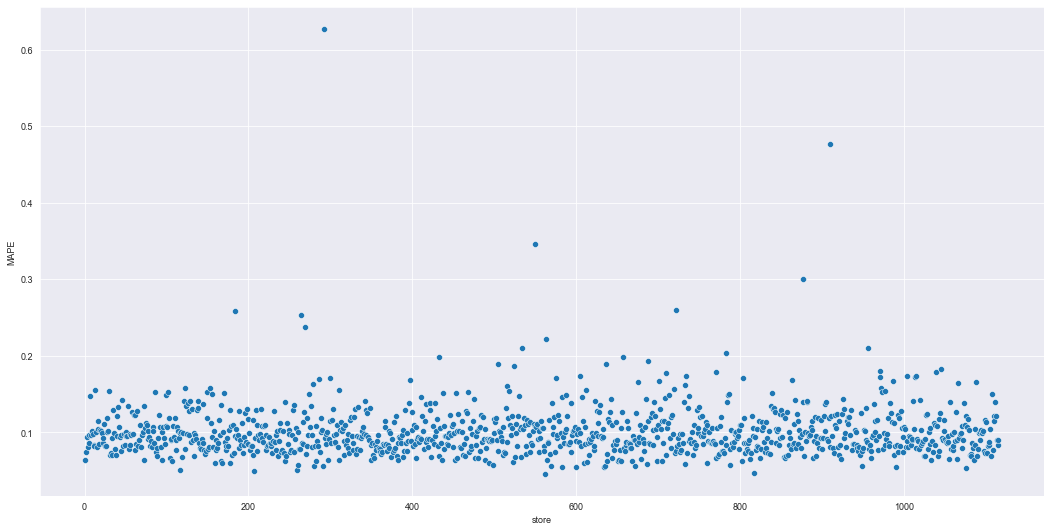

In [9]:
sns.scatterplot(x='store',y='MAPE',data=business_performance)

On the chart, it is possible to see that most Stores presents a low error, with only a couple of outliers.

### 3.1 Total Performance

On this subsection, another view of the performance that is also suitable for business teams is the total performance, that is, the sum of predicted sales of all the stores. Again, the results show the best and worst scenarios.

In [10]:
total_performance = business_performance[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index':'Scenario',0:'Values'})
total_performance['Values'] = total_performance['Values'].map('R${:,.2f}'.format)
total_performance

Scenario            Values
0     predictions  R$289,245,527.74
1  worst_scenario  R$288,479,654.29
2   best_scenario  R$290,011,401.19

## 4. Performance Report for Data Scientists

For Data Scientists, the model evaluation can obtain good insights by visualizing the error behaviour on the data. For that, some charts are generated below involving the pure error, which is the difference between the predictions and the true values, and the error rate, which is the ratio of predictions by true values.

In [11]:
test_data['error'] = test_data['sales'] - test_data['predictions']
test_data['error_rate'] = test_data['predictions'] /test_data['sales']

C:\Users\andre_\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='predictions', ylabel='error'>

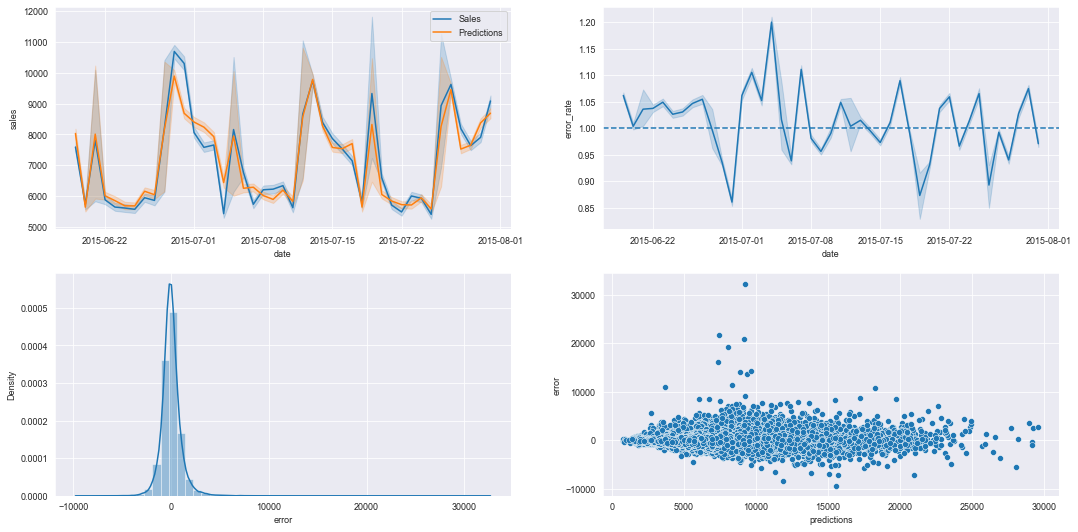

In [12]:
plt.subplot(2,2,1)
sns.lineplot(x='date',y='sales',data=test_data,label='Sales')
sns.lineplot(x='date',y='predictions',data=test_data,label='Predictions')

plt.subplot(2,2,2)
sns.lineplot(x='date',y='error_rate',data=test_data)
plt.axhline(1,linestyle='--')

plt.subplot(2,2,3)
sns.distplot(test_data['error'])

plt.subplot(2,2,4)
sns.scatterplot(x='predictions',y='error',data=test_data)


On the first chart, on the upper left, the sales predictions are compared to true values along time. In general, the predictions follow the sales trends well. In some peaks, however, the presence of large confidence intervals may show some inconsistency on model performance.

On the second chart, on the upper right, the error rate is plotted along time. A reference line on unitary values is also plotted, as error rates with this values means a right prediction. Despite some oscilations, the predictions remains around the reference line, which is a good signal.

On the third plot, on the lower left, the distribution of the error is analised, looking for any sistematic pattern. As a result, it is possible to see a high-concentrated distribution around zero, which is another good sign that indicates that the predictions, in general, are quite close to their true values.

Finally, on the last plot, on the lower right, the error is plotted against predictions on a scatter plot. This is a useful plot to detect with the model performs poorly specifically on any region of the test data. On this case, despite some larger errors on the region between 5000 and 10000, all of the rest remains on the same level of error, close to zero.